In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
from matplotlib import gridspec
import os
import pickle
from matplotlib.colors import LinearSegmentedColormap
import itertools
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import CPOM radar freeboard and snow depth data from 01/10/2019 - 30/04/2020
snow = Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'][3560:3773]
CS2_CPOM = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_CPOM_full.nc')['Radar Freeboard'])[3560:3773]
CS2S3_CPOM = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2S3_CPOM_full.nc')['Radar Freeboard'])[3560:3773]

### calculate correlations

In [3]:
# do smooth anoms for each grid cell

T1 = 15 ## for 31-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

CS2S3_CPOM_anoms_big = np.full(snow.shape,np.nan)
CS2_CPOM_anoms_big = np.full(snow.shape,np.nan)
snows_anoms_big = np.full(snow.shape,np.nan)

for day in tqdm.trange(snow.shape[0]):
    
    # each day, make the 31-day running mean (15 either side)
    
    snows_31day = np.nanmean(snow[day-T1:day+T1],axis=0) # 30-day running mean for each grid cell in time dimension
    CS2S3_CPOM_31day = np.nanmean(CS2S3_CPOM[day-T1:day+T1],axis=0)
    CS2_CPOM_31day = np.nanmean(CS2_CPOM[day-T1:day+T1],axis=0)
    
    # now make anomalies from 31-day means
    
    snows_anoms_big[day] = snow[day] - snows_31day 
    CS2S3_CPOM_anoms_big[day] = CS2S3_CPOM[day] - CS2S3_CPOM_31day
    CS2_CPOM_anoms_big[day] = CS2_CPOM[day] - CS2_CPOM_31day

CS2S3_CPOM_running_mean_anoms = np.full(snow.shape,np.nan)
CS2_CPOM_running_mean_anoms = np.full(snow.shape,np.nan)
sd_running_mean_anoms = np.full(snow.shape,np.nan)

# 9 day mean of anoms for each grid cell in time dimension
for day in tqdm.trange(snow.shape[0]):
        CS2_CPOM_running_mean_anoms[day] = np.nanmean(CS2_CPOM_anoms_big[day-T2:day+T2],axis=0)
        CS2S3_CPOM_running_mean_anoms[day] = np.nanmean(CS2S3_CPOM_anoms_big[day-T2:day+T2],axis=0) 
        sd_running_mean_anoms[day] = np.nanmean(snows_anoms_big[day-T2:day+T2],axis=0)

100%|████████████████████████████████████████| 213/213 [00:01<00:00, 130.54it/s]


In [4]:
all_ps = {}
all_rs = {}

# stats for 2019-2020 only
sats = ['CS2_CPOM','CS2S3_CPOM']
dics = [CS2_CPOM_running_mean_anoms,CS2S3_CPOM_running_mean_anoms]

for sat, dic in zip(sats,dics): 
    fb = dic
    snow = sd_running_mean_anoms

    ps = np.full((snow.shape[1],snow.shape[2]), np.nan)
    rs = np.full((snow.shape[1],snow.shape[2]), np.nan)

    for i, j in tqdm.tqdm(itertools.product(np.arange(snow.shape[1]),
                                  np.arange(snow.shape[2]))):
        # calculate p and r for full timeseries per grid cell

        mask = ~np.isnan(fb[:,i,j]) & ~np.isnan(snow[:,i,j]) # mask out cells with nan snow or nan freeb

        if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue


            rstats = pearsonr(fb[:,i,j][mask],snow[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
            r = np.round(rstats[0],decimals=2)
            p = np.round(rstats[1],decimals=3)
            ps[i,j] = p
            rs[i,j] = r

    all_ps[sat] = ps
    all_rs[sat] = rs

129600it [00:01, 77967.46it/s]
129600it [00:01, 76429.47it/s]


In [5]:
# calculate absolute difference between two plots
diff = np.abs(np.asarray(all_rs['CS2_CPOM'])) - np.abs(np.asarray(all_rs['CS2S3_CPOM']))
all_rs['CS2_CPOM - CS2S3_CPOM'] = diff

p = np.full((360,360),np.nan)

for i, j in tqdm.tqdm(itertools.product(np.arange(snow.shape[1]),
                              np.arange(snow.shape[2]))):
    if ~np.isnan(all_rs['CS2_CPOM'][i,j]) or ~np.isnan(all_rs['CS2S3_CPOM'][i,j]):
        p[i,j] = 0.06
    if (all_ps['CS2_CPOM'][i,j]<0.05) & (all_ps['CS2S3_CPOM'][i,j]<0.05):
        p[i,j] = 0.04
        
all_ps['CS2_CPOM - CS2S3_CPOM'] = p

129600it [00:00, 224330.52it/s]


In [6]:
### create MYI area line
datapath = '/Users/carmennab/Dropbox/OI_PolarSnow/data/CDS_icetype/'

days = np.arange(0,len(snow))
dates = [datetime.date(2019,10,1)+datetime.timedelta(days=np.int(days)) for days in days]

all_MYI = np.full((len(snow),432, 432),np.nan)

for day in days:#key is a date, so looping through each day for which we have gridded CS2 obs in this season
    date = dates[day].strftime('%Y%m%d')
    try:
        icetype = Dataset(datapath+'ice_type_nh_ease2-250_cdr-v2p0_'+str(date)+'1200.nc')
        ice_type = np.asarray(icetype['ice_type'][0])
        ice_type[ice_type>3]=0
        ice_type[ice_type<3]=0 
        ice_type[ice_type==3]=1
        all_MYI[day] = ice_type
    except:
        pass
    
MYI_days = (all_MYI == 1).sum(axis = 0).astype(np.float32)    
icetype_lon = np.array(icetype['lon'])
icetype_lat = np.array(icetype['lat'])
day_ave = MYI_days/len(snow)
day_ave[icetype_lat>89]=0.6 # remove polehole

lon2d_greater = ma.masked_greater(np.array(icetype_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(icetype_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(day_ave, mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(day_ave, mask=lon2d_greater.mask)

### plot figure

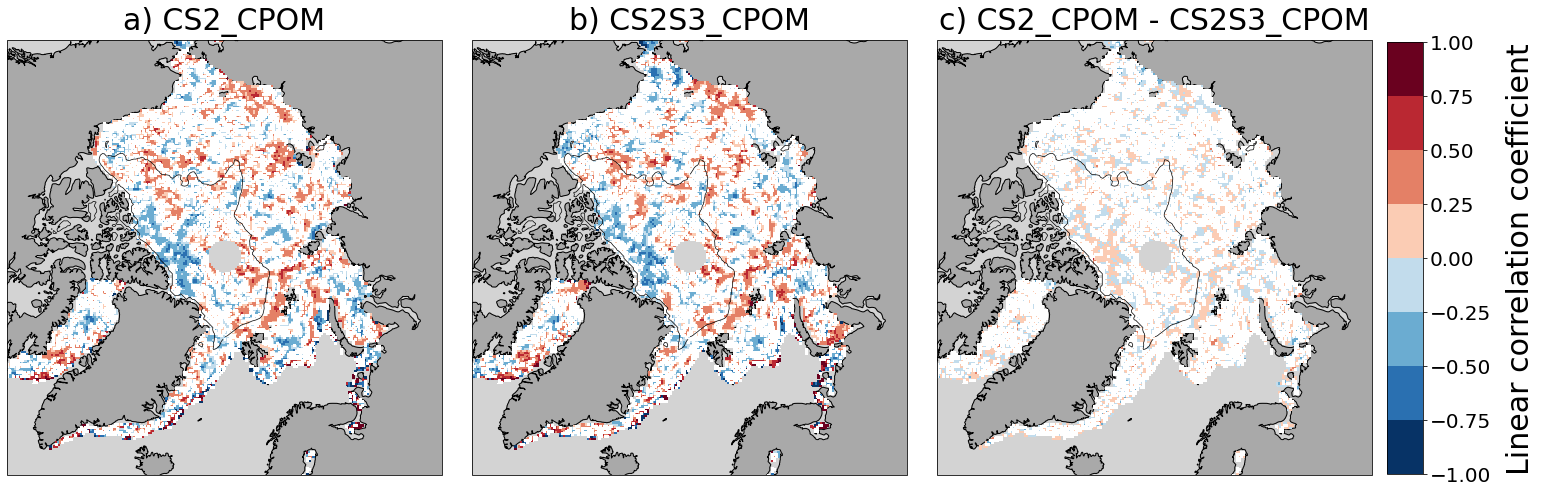

In [8]:
# Correlation between SM-LG and WG interpolated freeboards smoothed anomalies for 2019-2020 period

lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lat_25km.npy')
lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lon_25km.npy')

sats = ['CS2_CPOM','CS2S3_CPOM','CS2_CPOM - CS2S3_CPOM']
nums = ['a) ','b) ','c) ']
list_colors = ['#073366','#2A70B1','#6BACD1','#C2DCEC','#FBCCB4','#E48066','#BA2832','#6A011F'] 

fig = plt.figure(figsize=(25,8))
spec = gridspec.GridSpec(ncols=3, nrows=1,hspace=0.,wspace=0.)

for counter in np.arange(0,3):
    ax = fig.add_subplot(spec[counter],projection=ccrs.NorthPolarStereo())
    rs = all_rs[sats[counter]]
    ps = all_ps[sats[counter]]    

    rs[ps>0.05] = 1000
    grey = rs.copy()
    grey[grey <1000] = np.nan
    rs[rs==1000] = np.nan

    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.add_feature(cartopy.feature.OCEAN, color='lightgrey', edgecolor='black')
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.coastlines()
    cm = LinearSegmentedColormap.from_list('map', list_colors, N = 8)
    p_map = ax.pcolormesh(lons,lats,rs,cmap=cm,vmin=-1,vmax=1,transform=ccrs.PlateCarree())
    ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=1000,vmax=6000,transform=ccrs.PlateCarree())
    ax.set_title(nums[counter]+sats[counter],fontsize=30, pad=10)
    
    cont_less = ax.contour(lon2d_lesser,
                  lat2d_lesser,
                  ice_type_lesser,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=0.7)

    cont_Great = ax.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=0.7)
    
    if counter == 2: 
        cbar_ax = fig.add_axes([0.9, 0.1255, 0.02, 0.75]) # x, y, width, height
        a = fig.colorbar(p_map, cax=cbar_ax)
        a.ax.tick_params(labelsize=20)
        a.set_label("Linear correlation coefficient", fontsize = 30 ,labelpad = 15)

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/cs2_vs_cs2s3.png',bbox_inches = "tight", dpi = 400)